In [1]:
%cd "/content/drive/MyDrive/Image Classification/CLS - tensorflow 2"

/content/drive/MyDrive/Image Classification/CLS - tensorflow 2


In [2]:
import cv2
import numbers
import collections.abc as collections
import numpy as np
import math
import torch
import torchvision
import torchvision.transforms.functional as TF
from visualizer import *
from augmenter.base_transform import *
from utils.someones import *
from augmenter.base_transform import BaseTransform, BaseRandomTransform, ComposeTransform
from utils.auxiliary_processing import random_range, is_numpy_image
import random

In [3]:
img_path = "/content/drive/MyDrive/Datasets/test.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orin_image = image.copy()
# visual_image([image], ['image'])


In [4]:
def detach(tensor):
    return tensor.detach().cpu().numpy()


def torch2image(tensor):
  img = detach(tensor)
  if len(img.shape) == 4:
      img = np.transpose(img, [0, 2, 3, 1])
  else:
      img = np.transpose(img, (1, 2, 0))
  return img

def compair_image(img1, img2):
    return (img1 == img2).sum() == img1.shape[0] * img1.shape[1] * img1.shape[2]

In [5]:
def to_grayscale(image, out_channels=1):
    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))

    if out_channels == 1:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif out_channels == 3:
        image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
    else:
        raise ValueError('num_output_channels should be either 1 or 3')

    return image

class Grayscale(BaseTransform):
    def __init__(self, out_channels=1):
        self.out_channels = out_channels

    def image_transform(self, image):
        return to_grayscale(image, self.out_channels)


class RandomGrayscale(BaseRandomTransform):
    def __init__(self, out_channels=3, prob=0.1):
        self.out_channels = out_channels
        self.prob = prob

    def image_transform(self, image):
        return to_grayscale(image, self.out_channels)

In [6]:
aug = RandomGrayscale(3, prob=0.9)

new_image = aug([image])[0]
print(new_image.shape)
# visual_image([new_image], [''], size=(5, 5))

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

(1358, 1074, 3)
compair orin image: True
compair new image: True


In [7]:
def adjust_brightness(image, brightness_factor):
    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))

    img = image.astype(np.float32) * brightness_factor
    img = img.clip(min=0, max=255)
    return img.astype(image.dtype)


class AdjustBrightness(BaseTransform):
    def __init__(self, brightness_factor=1):
        self.brightness_factor = brightness_factor

    def image_transform(self, image):
        return adjust_brightness(image, self.brightness_factor)


class RandomAdjustBrightness(BaseTransform):
    def __init__(self, brightness_range=1):
        assert (isinstance(brightness_range, (int, float)) and brightness_range > 0) or (isinstance(brightness_range, collections.Iterable) and len(brightness_range) == 2)
        self.brightness_range = brightness_range

    @staticmethod
    def get_params(brightness):
        brightness_factor = 1.0

        if isinstance(brightness, numbers.Number):
            brightness_factor = random.uniform(max(0, 1 - brightness), 1 + brightness)
        else:
            if brightness[0] > 0 and brightness[1] > 0:
                brightness_factor = random.uniform(brightness[0], brightness[1])

        if brightness_factor < 0:
            brightness_factor = 1.0

        return brightness_factor

    def image_transform(self, image):
        brightness_factor = self.get_params(self.brightness_range)
        return adjust_brightness(image, brightness_factor)

In [8]:
aug = AdjustBrightness(2)
new_image = aug([image])[0]
# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 207.511 >
compair orin image: True
compair new image: False


In [9]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = TF.adjust_brightness(x,  2)
y = torch2image(x)
# visual_image([y], [''], size=(5, 5))
tensor_value_info(y)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 207.511 >


In [10]:
aug = RandomAdjustBrightness([1, 4])
new_image = aug([image])[0]
# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 148.369 >
compair orin image: True
compair new image: False


In [100]:
def adjust_contrast(image, contrast_factor):
    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))

    img = image.astype(np.float32)
    mean = round(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).mean())
    img = (1 - contrast_factor) * mean + contrast_factor * img
    img = img.clip(min=0, max=255)
    return img.astype(image.dtype)


class AdjustContrast(BaseTransform):
    def __init__(self, contrast_factor=1):
        self.contrast_factor = contrast_factor

    def image_transform(self, image):
        return adjust_contrast(image, self.contrast_factor)

class RandomAdjustContrast(BaseTransform):
    def __init__(self, contrast_range=1):
        assert (isinstance(contrast_range, (int, float)) and contrast_range > 0) or (isinstance(contrast_range, collections.Iterable) and len(contrast_range) == 2)
        self.contrast_range = contrast_range

    @staticmethod
    def get_params(contrast):
        contrast_factor = 1.0

        if isinstance(contrast, numbers.Number):
            contrast_factor = random.uniform(max(0, 1 - contrast), 1 + contrast)
        elif isinstance(contrast, (tuple, list)):
            if contrast[0] > 0 and contrast[1] > 0:
                contrast_factor = random.uniform(contrast[0], contrast[1])

        if contrast_factor < 0:
            contrast_factor = 1.0

        return contrast_factor

    def image_transform(self, image):
        contrast_factor = self.get_params(self.contrast_range)
        return adjust_contrast(image, contrast_factor)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 121.256 >
compair orin image: True
compair new image: False


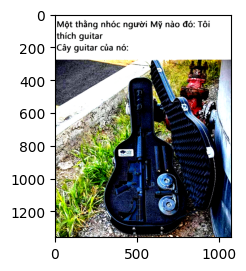

In [102]:
aug = AdjustContrast(3)
new_image = aug([image])[0]
visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

In [13]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = TF.adjust_contrast(x, 4)
y = torch2image(x)
# visual_image([y], [''], size=(5, 5))
tensor_value_info(y)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 118.538 >


In [14]:
aug = RandomAdjustContrast(1)
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 129.569 >
compair orin image: True
compair new image: False


In [15]:
def adjust_saturation(image, saturation_factor):
    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))

    img = image.astype(np.float32)
    degenerate = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
    img = (1 - saturation_factor) * degenerate + saturation_factor * img
    img = img.clip(min=0, max=255)
    return img.astype(image.dtype)


class AdjustSaturation(BaseTransform):
    def __init__(self, saturation_factor=1):
        self.saturation_factor = saturation_factor

    def image_transform(self, image):
        return adjust_saturation(image, self.saturation_factor)


class RandomAdjustSaturation(BaseTransform):
    def __init__(self, saturation_range=1):
        assert (isinstance(saturation_range, (int, float)) and saturation_range > 0) or (isinstance(saturation_range, collections.Iterable) and len(saturation_range) == 2)
        self.saturation_range = saturation_range

    @staticmethod
    def get_params(saturation):
        saturation_factor = 1.0

        if isinstance(saturation, numbers.Number) and saturation > 0:
            saturation_factor = random.uniform(max(0, 1 - saturation), 1 + saturation)
        elif isinstance(saturation, (tuple, list)):
            if saturation[0] > 0 and saturation[1] > 0:
                saturation_factor = random.uniform(saturation[0], saturation[1])

        if saturation_factor < 0:
            saturation_factor = 1.0

        return saturation_factor

    def image_transform(self, image):
        saturation_factor = self.get_params(self.saturation_range)
        return adjust_saturation(image, saturation_factor)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 140.276 >
compair orin image: True
compair new image: False


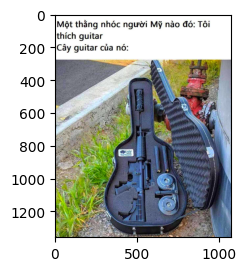

In [103]:
aug = AdjustSaturation(2.)
new_image = aug([image])[0]
visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

In [17]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = TF.adjust_saturation(x, 4)
y = torch2image(x)
# visual_image([y], [''], size=(5, 5))
tensor_value_info(y)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 142.213 >


In [18]:
aug = RandomAdjustSaturation(4.)
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 140.559 >
compair orin image: True
compair new image: False


In [19]:
def adjust_hue(image, hue_factor):
    if not(-0.5 <= hue_factor <= 0.5):
        raise ValueError('hue_factor is not in [-0.5, 0.5].'.format(hue_factor))

    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))

    img = image.astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
    hsv[..., 0] += np.uint8(hue_factor * 255)

    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB_FULL)
    return img.astype(image.dtype)


class AdjustHue(BaseTransform):
    def __init__(self, hue_factor=1):
        self.hue_factor = hue_factor

    def image_transform(self, image):
        return adjust_hue(image, self.hue_factor)


class RandomAdjustHue(BaseTransform):
    def __init__(self, hue_range=1):
        assert (isinstance(hue_range, (int, float)) and hue_range > 0) or (isinstance(hue_range, collections.Iterable) and len(hue_range) == 2)
        self.hue_range = hue_range

    @staticmethod
    def get_params(hue):
        hue_factor = 0.0

        if isinstance(hue, numbers.Number) and hue > 0:
            hue_factor = random.uniform(-hue, hue)
        elif isinstance(hue, (tuple, list)):
            if hue[0] > 0 and hue[1] > 0:
                hue_factor = random.uniform(hue[0], hue[1])

        if not(-0.5 <= hue_factor <= 0.5):
            hue_factor = 0.0

        return hue_factor

    def image_transform(self, image):
        hue_factor = self.get_params(self.hue_range)
        return adjust_hue(image, hue_factor)

In [20]:
aug = AdjustHue(-0.4)
new_image = aug([image])[0]
# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 142.242 >
compair orin image: True
compair new image: False


In [21]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = TF.adjust_hue(x, -0.4)
y = torch2image(x)
# visual_image([y], [''], size=(5, 5))
tensor_value_info(y)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 142.228 >


In [22]:
aug = RandomAdjustHue(0.4)
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 140.125 >
compair orin image: True
compair new image: False


In [23]:
def adjust_gamma(img, gamma, gain=1):
    if not is_numpy_image(img):
        raise TypeError('img should be image. Got {}'.format(type(img)))

    if gamma < 0:
        raise ValueError('Gamma should be a non-negative real number')

    im = img.astype(np.float32)
    im = 255. * gain * np.power(im / 255., gamma)
    im = im.clip(min=0., max=255.)
    return im.astype(img.dtype)


class AdjustGamma(BaseTransform):
    def __init__(self, gamma, gain=1):
        self.gamma = gamma
        self.gain  = gain

    def image_transform(self, image):
        return adjust_gamma(image, self.gamma, self.gain)


class RandomAdjustGamma(BaseTransform):
    def __init__(self, gamma, gain=1):
        if gamma < 0:
            raise ValueError('Gamma should be a non-negative real number')
        self.gamma = gamma
        self.gain = gain

    @staticmethod
    def get_params(gamma):
        if isinstance(gamma, numbers.Number) and gamma > 0:
            gamma_factor = random.uniform(0, gamma)
        else:
            if gamma[0] > 0 and gamma[1] > 0:
                gamma_factor = random.uniform(gamma[0], gamma[1])
        return gamma_factor

    def image_transform(self, image):
        gamma_factor = self.get_params(self.gamma)
        return adjust_gamma(image, gamma_factor, gain=self.gain)

In [24]:
aug = AdjustGamma(2, 3)
new_image = aug([image])[0]
# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 169.015 >
compair orin image: True
compair new image: False


In [25]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = TF.adjust_gamma(x, 2, 3)
y = torch2image(x)
# visual_image([y], [''], size=(5, 5))
tensor_value_info(y)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 169.252 >


In [26]:
aug = RandomAdjustGamma(5)
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 130.550 >
compair orin image: True
compair new image: False


In [27]:
class ColorJitter(BaseTransform):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.transforms = []
        assert isinstance(brightness, float) or (isinstance(brightness, collections.Iterable) and len(brightness) == 2)
        assert isinstance(contrast, float) or (isinstance(contrast, collections.Iterable) and len(contrast) == 2)
        assert isinstance(saturation, float) or (isinstance(saturation, collections.Iterable) and len(saturation) == 2)
        assert isinstance(hue, float) or (isinstance(hue, collections.Iterable) and len(hue) == 2)

        if brightness > 0:
            self.transforms.append(RandomAdjustBrightness(brightness))

        if contrast > 0:
            self.transforms.append(RandomAdjustContrast(contrast))

        if saturation > 0:
            self.transforms.append(RandomAdjustSaturation(saturation))

        if hue > 0:
            self.transforms.append(RandomAdjustHue(hue))

    def image_transform(self, image):
        random.shuffle(self.transforms)
        transform = ComposeTransform(self.transforms)
        return transform(image)

In [28]:
aug = ColorJitter(1., 2., 3., 0.3)
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 103.000 mean: 38.057 >
compair orin image: True
compair new image: False


In [29]:
x = torch.from_numpy(np.transpose(image, (2, 0, 1)).copy())

x = torchvision.transforms.ColorJitter(1., 2., 3., 0.3)(x)
y = torch2image(x)
print(y.shape)
# visual_image([y], [''], size=(5, 5))


(1358, 1074, 3)


In [30]:
def gaussian_noise(image, mean, std):
    assert isinstance(mean, numbers.Number) and mean >= 0, 'mean should be a positive value'
    assert isinstance(std, numbers.Number) and std >= 0, 'std should be a positive value'
    imgtype = image.dtype
    gauss = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy = np.clip((1 + gauss) * image.astype(np.float32), 0, 255)
    return noisy.astype(imgtype)


class GaussianNoise(BaseTransform):
    def __init__(self, mean, std):
        self.mean = mean
        self.std  = std

    def image_transform(self, image):
        return gaussian_noise(image, self.mean, self.std)


class RandomGaussianNoise(BaseRandomTransform):
    def __init__(self, mean_range=0, std_range=0.1, prob=0.5):
        assert isinstance(mean_range, (int, float)) or (isinstance(mean_range, collections.Iterable) and len(mean_range) == 2)
        assert isinstance(std_range, (int, float)) or (isinstance(std_range, collections.Iterable) and len(std_range) == 2)
        self.mean_range = mean_range
        self.std_range  = std_range
        self.prob       = prob

    @staticmethod
    def get_params(mean, std):
        if isinstance(mean, numbers.Number):
            mean_factor = random.uniform(0, mean)
        else:
            mean_factor = random.uniform(mean[0], mean[1])

        if isinstance(std, numbers.Number):
            std_factor = random.uniform(0, std)
        else:
            std_factor = random.uniform(std[0], std[1])
        return mean_factor, std_factor

    def image_transform(self, image):
        ret = self.get_params(self.mean_range, self.std_range)
        return gaussian_noise(image, *ret)

In [31]:
aug = GaussianNoise(5, 7)
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 186.797 >
compair orin image: True
compair new image: False


In [32]:
aug = RandomGaussianNoise(5, 7, prob=1)
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 233.427 >
compair orin image: True
compair new image: False


In [33]:
def poisson_noise(image):
    imgtype = image.dtype
    image = image.astype(np.float32)/255.0
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = 255 * np.clip(np.random.poisson(image.astype(np.float32) * vals) / float(vals), 0, 1)
    return noisy.astype(imgtype)


class PoissonNoise(BaseTransform):

    def image_transform(self, image):
        return poisson_noise(image)


class RandomPoissonNoise(BaseRandomTransform):

    def image_transform(self, image):
        return poisson_noise(image)

In [34]:
aug = PoissonNoise()
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 139.673 >
compair orin image: True
compair new image: False


In [35]:
def salt_and_pepper(img, threshold=0.01):
    imgtype = img.dtype
    rnd = np.random.rand(img.shape[0], img.shape[1])
    noisy = img.copy()
    noisy[rnd < threshold / 2] = 0.0
    noisy[rnd > 1 - threshold / 2] = 255.0
    return noisy.astype(imgtype)


class SaltPepperNoise(BaseTransform):
    def __init__(self, threshold=0.1):
        self.threshold = threshold

    def image_transform(self, image):
        return salt_and_pepper(image, self.threshold)


class RandomSaltPepperNoise(BaseRandomTransform):
    def __init__(self, threshold=0.1, prob=0.5):
        self.threshold = threshold
        self.prob      = prob

    def image_transform(self, image):
        return salt_and_pepper(image, self.threshold)

In [36]:
aug = RandomSaltPepperNoise(0.4)
new_image = aug([image])[0]

# visual_image([new_image], [''], size=(5, 5))
tensor_value_info(new_image)

print('compair orin image:', compair_image(image, orin_image))
print('compair new image:', compair_image(image, new_image))

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
compair orin image: True
compair new image: True


In [37]:
import requests
import io

def blend_random_image(image, ratio=0.8):
    URL = 'https://picsum.photos/{}/{}/?random'

    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))

    h, w = image.shape[:2]
    try:
        r = requests.get(URL.format(w, h), allow_redirects=True)
        f = io.BytesIO(r.content)
        file_bytes = np.asarray(bytearray(f.read()), dtype=np.uint8)
        random_img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
        return cv2.addWeighted(image, ratio, random_img, 1 - ratio, 0)
    except requests.exceptions.ConnectionError as e:
        print('Unable to download image. Error: {}'.format(e))
    except Exception as e:
        print('Unknown error occurred "{}"'.format(e))


class BlendRandomImage(BaseTransform):
    def __init__(self, ratio=0.8):
        self.ratio = ratio

    def image_transform(self, image):
        return blend_random_image(image, self.ratio)


class RandomBlendRandomImage(BaseRandomTransform):
    def __init__(self, ratio=0.8, prob=0.5):
        self.ratio = ratio
        self.prob  = prob

    def image_transform(self, image):
        return blend_random_image(image, self.ratio)

In [38]:
aug_img = RandomBlendRandomImage(0.4)(image)

# visual_image([aug_img], [''])

In [39]:
def median_blur(image, ksize_norm=0.05):

    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))
    try:
        k_size = int(min(image.shape[:2]) * ksize_norm)
        k_size = k_size + 1 if k_size % 2 == 0 else k_size

        if k_size <= 2:
            return image
        return cv2.medianBlur(image, k_size)
    except:
        k_size = random.choice([3, 5, 7, 9, 13, 15, 17, 19])
        return cv2.medianBlur(image, k_size)


class MedianBlur(BaseTransform):
    def __init__(self, ksize_norm=0.05):
        self.ksize_norm = ksize_norm

    def image_transform(self, image):
        return median_blur(image, self.ksize_norm)


class RandomMedianBlur(BaseRandomTransform):
    def __init__(self, ksize_norm=0.8, prob=0.5):
        self.ksize_norm = ksize_norm
        self.prob       = prob

    @staticmethod
    def get_params(ksize):
        ksize_factor = 1.0

        if isinstance(ksize, numbers.Number) and ksize > 0:
            ksize_factor = random.uniform(0, ksize)
        else:
            if ksize[0] > 0 and ksize[1] > 0:
                ksize_factor = random.uniform(ksize[0], ksize[1])

        if ksize_factor < 0:
            ksize_factor = 1.0

        return ksize_factor

    def image_transform(self, image):
        ksize_norm = self.get_params(self.ksize_norm)
        return median_blur(image, ksize_norm)

In [40]:
aug_img = RandomMedianBlur(1, prob=1)(image)

# visual_image([aug_img], [''])

In [41]:
def radial_gradient(image,
                    inner_color=150,
                    outer_color=30,
                    center=None,
                    max_distance=None,
                    rect=False,
                    random_distance=False):

    def apply_radial(img, center, max_distance, inner_color, outer_color, rect=False):
        tmp = np.full(img.shape, outer_color, dtype=np.uint8)
        tmp_height, tmp_width = tmp.shape[:2]
        kernel = None

        left = max(0, 0 - (center[0] - max_distance))
        top = max(0, 0 - (center[1] - max_distance))
        right = max(0, (center[0] + max_distance) - tmp_width)
        bottom = max(0, (center[1] + max_distance) - tmp_height)
        tmp = cv2.copyMakeBorder(tmp, top, bottom, left, right, cv2.BORDER_CONSTANT)

        if rect:
            if random.getrandbits(1):
                dist = random.randint(10, int(.2 * tmp_width))
                cv2.rectangle(tmp, (center[0] - dist, 0), (center[0] + dist, tmp_height),
                              inner_color,
                              thickness=cv2.FILLED)
                k_size = dist if dist % 2 == 1 else dist - 1
                kernel = (k_size, 1)
            else:
                dist = random.randint(10, int(.2 * tmp_height))
                cv2.rectangle(tmp, (0, center[1] - dist), (tmp_width, center[1] + dist),
                              inner_color,
                              thickness=cv2.FILLED)
                k_size = dist if dist % 2 == 1 else dist - 1
                kernel = (1, k_size)
        else:
            cv2.circle(tmp, (center[0] + left, center[1] + top),
                       int(max_distance / 1.5),
                       inner_color,
                       thickness=cv2.FILLED)

        kernel = kernel if kernel else (max_distance, max_distance)
        tmp = cv2.blur(tmp, kernel, borderType=cv2.BORDER_CONSTANT)
        tmp = tmp[top:tmp.shape[0] - bottom, left:tmp.shape[1] - right]

        return np.clip(img.astype(np.uint16) + tmp.astype(np.uint16), 0, 255).astype(np.uint8)

    im_height, im_width, im_depth = image.shape
    inner_color = im_depth * [inner_color]
    outer_color = im_depth * [outer_color]

    if center is None:
        center = random.randint(0, im_height), random.randint(0, im_width)

    if not rect:
        if max_distance is None:
            if random_distance:
                size = max(im_width, im_height)
                max_distance = size * random.uniform(.1, .3)
            else:
                max_distance = 0
                corners = [(0, 0), (im_height, 0), (0, im_width), (im_height, im_width)]
                for corner in corners:
                    distance = math.sqrt((corner[0] - center[0])**2 +
                                          (corner[1] - center[1])**2)
                    max_distance = max(distance, max_distance)

    return apply_radial(image,
                        center,
                        int(max_distance),
                        inner_color,
                        outer_color,
                        rect=rect)


class RadialGradient(BaseTransform):
    def __init__(self,
                 inner_color=150,
                 outer_color=30,
                 center=None,
                 max_distance=None,
                 rect=False,
                 random_distance=False):
        self.inner_color = inner_color
        self.outer_color = outer_color
        self.center = center
        self.max_distance = max_distance
        self.rect = rect
        self.random_distance = random_distance

    def image_transform(self, image):
        return radial_gradient(image, self.inner_color,
                               self.outer_color, self.center,
                               self.max_distance, self.rect,
                               self.random_distance)


class RandomRadialGradient(BaseRandomTransform):
    def __init__(self,
                 inner_color=150,
                 outer_color=30,
                 center=None,
                 max_distance=None,
                 rect=False,
                 random_distance=False,
                 prob=0.5):
        self.inner_color = inner_color
        self.outer_color = outer_color
        self.center = center
        self.max_distance = max_distance
        self.rect = rect
        self.random_distance = random_distance
        self.prob = prob

    def image_transform(self, image):
        return radial_gradient(image, self.inner_color,
                               self.outer_color, self.center,
                               self.max_distance, self.rect,
                               self.random_distance)

In [42]:
aug_img = RandomRadialGradient()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >


In [43]:
def linear_gradient(image, orientation="horizontal", edge_brightness=(.1, .3)):
    assert isinstance(edge_brightness, tuple) and len(edge_brightness) == 2, \
        "Argument edge_brightness should be a tuple with size 2."
    assert 0. < edge_brightness[0] < 1. and 0. < edge_brightness[1] < 1., \
        "Values of an edge_brightness argument should be in the [0, 1] range."
    assert orientation in ['horizontal', 'vertical'], "Unknown orientation value."

    color1 = int(edge_brightness[0] * 255)
    color2 = int(edge_brightness[1] * 255)
    reverse = bool(random.getrandbits(1))

    image = np.int16(image.copy())
    dim = image.shape[1] if orientation == "horizontal" else image.shape[0]
    for i in range(dim):
        coeff = i / float(dim)
        if reverse:
            coeff = 1. - coeff
        diff = int((color2 - color1) * coeff)
        if orientation == "horizontal":
            image[:, i, 0:3] = np.where(image[:, i, 0:3] + color1 + diff < 255,
                                        image[:, i, 0:3] + color1 + diff, 255)
        else:
            image[i, :, 0:3] = np.where(image[i, :, 0:3] + color1 + diff < 255,
                                        image[i, :, 0:3] + color1 + diff, 255)

    return image.astype(np.uint8)


class LinearGradient(BaseTransform):
    def __init__(self,
                 orientation="horizontal",
                 edge_brightness=(.1, .3)):
        self.orientation = orientation
        self.edge_brightness = edge_brightness

    def image_transform(self, image):
        return linear_gradient(image, self.orientation, self.edge_brightness)


class RandomRadialGradient(BaseRandomTransform):
    def __init__(self,
                 orientation="horizontal",
                 edge_brightness=(.1, .3),
                 prob=0.5):
        self.orientation = orientation
        self.edge_brightness = edge_brightness
        self.prob = prob

    def image_transform(self, image):
        return linear_gradient(image, self.orientation, self.edge_brightness)


In [44]:
aug_img = LinearGradient()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 25.000 max: 255.000 mean: 181.161 >


In [45]:
def variable_blur(image, modes=('linear', 'radial'), ksize_norm=.2):

    def linear_mask(image):
      mask = np.zeros(image.shape, dtype=np.uint8)
      edge1 = random.uniform(0.7, 1.)
      edge2 = random.uniform(0, .3)
      return linear_gradient(mask,
                             orientation=random.choice(['horizontal', 'vertical']),
                             edge_brightness=(edge1, edge2))

    def radial_mask(image):
        max_dim = max(image.shape)
        mask = np.zeros(image.shape, dtype=np.uint8)
        return radial_gradient(mask,
                               inner_color=255,
                               outer_color=10,
                               max_distance=max_dim * random.uniform(.35, .65))

    for elem in modes:
        assert elem in ['linear', 'radial']

    k_size = int(min(image.shape[:2]) * ksize_norm)
    k_size = k_size + 1 if k_size % 2 == 0 else k_size
    if k_size <= 2:
        return image

    image_blurred = cv2.blur(image.copy(), ksize=(k_size, k_size))

    mode = random.choice(modes)

    if mode == 'linear':
        mask = linear_mask(image)
    elif mode == 'radial':
        mask = radial_mask(image)

    image = image.astype(np.float32)
    image_blurred = image_blurred.astype(np.float32)
    mask = mask.astype(np.float32) / 255

    image = cv2.multiply(mask, image).astype(np.uint8)
    image_blurred = cv2.multiply(1.0 - mask, image_blurred).astype(np.uint8)

    return cv2.add(image, image_blurred)


class VariableBlur(BaseTransform):
    def __init__(self, modes=('linear', 'radial'), ksize_norm=.2):
        self.modes = modes
        self.ksize_norm = ksize_norm

    def image_transform(self, image):
        return variable_blur(image, self.modes, self.ksize_norm)


class RandomVariableBlur(BaseRandomTransform):
    def __init__(self, modes=('linear', 'radial'), ksize_norm=.2, prob=0.5):
        self.modes = modes
        self.ksize_norm = ksize_norm
        self.prob = prob

    def image_transform(self, image):
        return variable_blur(image, self.modes, self.ksize_norm)


In [46]:
# visual_image([RandomVariableBlur()(image)], [''])


In [47]:
def motion_blur(image, ksize_norm=0.1):
    k_size = int(min(image.shape[:2]) * ksize_norm)
    k_size = k_size + 1 if k_size % 2 == 0 else k_size
    if k_size <= 2:
        return image

    x1, x2 = random.randint(0, k_size - 1), random.randint(0, k_size - 1)
    y1, y2 = random.randint(0, k_size - 1), random.randint(0, k_size - 1)

    kernel_mtx = np.zeros((k_size, k_size), dtype=np.uint8)
    cv2.line(kernel_mtx, (x1, y1), (x2, y2), 1, thickness=1)
    return cv2.filter2D(image, -1, kernel_mtx / np.sum(kernel_mtx))


class MotionBlur(BaseTransform):
    def __init__(self, ksize_norm=0.1):
        self.ksize_norm = ksize_norm

    def image_transform(self, image):
        return motion_blur(image, self.ksize_norm)


class RandomMotionBlur(BaseRandomTransform):
    def __init__(self, ksize_norm=0.1, prob=0.5):
        self.ksize_norm = ksize_norm
        self.prob = prob

    def image_transform(self, image):
        return motion_blur(image, self.ksize_norm)


In [48]:
aug_img = MotionBlur()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 13.000 max: 255.000 mean: 143.174 >


In [49]:
def gaussian_blur(image, ksize_norm=.4, sigma=5, direction=None):
    assert direction in ('horizontal', 'vertical', None)

    k_size = int(min(image.shape[:2]) * ksize_norm)
    k_size = k_size + 1 if k_size % 2 == 0 else k_size
    if k_size <= 2:
        return image

    if direction == "horizontal":
        return cv2.GaussianBlur(image, (k_size, 1), sigmaX=sigma, sigmaY=sigma)
    elif direction == "vertical":
        return cv2.GaussianBlur(image, (1, k_size), sigmaX=sigma, sigmaY=sigma)
    else:
        return cv2.GaussianBlur(image, (k_size, k_size), sigmaX=sigma, sigmaY=sigma)


class GaussianBlur(BaseTransform):
    def __init__(self, ksize_norm=.4, sigma=5, direction=None):
        self.ksize_norm = ksize_norm
        self.sigma = sigma
        self.direction = direction

    def image_transform(self, image):
        return gaussian_blur(image, self.ksize_norm, self.sigma, self.direction)


class RandomGaussianBlur(BaseRandomTransform):
    def __init__(self, ksize_norm=.4, sigma=5, direction=None, prob=0.5):
        self.ksize_norm = ksize_norm
        self.sigma = sigma
        self.direction = direction
        self.prob = prob

    def image_transform(self, image):
        return gaussian_blur(image, self.ksize_norm, self.sigma, self.direction)


In [50]:
aug_img = GaussianBlur()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 7.000 max: 255.000 mean: 141.262 >


In [51]:
def erosion_or_dilation(image, kernel_size=5, reversed=False):
    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))

    img = image.copy()
    kernel_size = kernel_size if kernel_size % 2 != 0 else kernel_size + 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    er, dil = cv2.erode, cv2.dilate
    if reversed:
        er, dil = dil, er

    img[:, :, 0] = er(img[:, :, 0], kernel, iterations=1)
    img[:, :, 1] = er(img[:, :, 1], kernel, iterations=1)
    img[:, :, 2] = er(img[:, :, 2], kernel, iterations=1)
    if img.shape[2] > 3:
        img[:, :, 3] = dil(img[:, :, 3], kernel, iterations=1)

    return img


class Erosion(BaseTransform):
    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def image_transform(self, image):
        return erosion_or_dilation(image, self.kernel_size, reversed=False)


class RandomErosion(BaseRandomTransform):
    def __init__(self, kernel_size=5, prob=0.5):
        self.kernel_size = kernel_size
        self.prob = prob

    def image_transform(self, image):
        return erosion_or_dilation(image, self.kernel_size, reversed=False)


class Dilation(BaseTransform):
    def __init__(self, kernel_size=5):
        self.kernel_size = kernel_size

    def image_transform(self, image):
        return erosion_or_dilation(image, self.kernel_size, reversed=True)


class RandomDilation(BaseRandomTransform):
    def __init__(self, kernel_size=5, prob=0.5):
        self.kernel_size = kernel_size
        self.prob = prob

    def image_transform(self, image):
        return erosion_or_dilation(image, self.kernel_size, reversed=True)

In [52]:
aug_img = Erosion()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 114.955 >


In [53]:
aug_img = Dilation()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 2.000 max: 255.000 mean: 166.967 >


In [54]:
def scratches(image, num_scratches=20, alpha=None):
    alpha = alpha if alpha is not None else .5
    h, w = image.shape[:2]
    min_x, min_y = 0, 0
    max_x, max_y = 2 * w, 2 * h

    scratches = np.zeros((max_y, max_x, 3), np.uint8)
    scratches[:] = 0

    for i in range(0, num_scratches):
        x1 = random.randint(min_x, max_x)
        x2 = random.randint(min_x, max_x)
        y1 = random.randint(min_y, max_y)
        y2 = random.randint(min_y, max_y)

        color = tuple([random.randint(0, 255)] * 3)

        cv2.line(scratches, (x1, y1), (x2, y2), color, thickness=1, lineType=cv2.LINE_AA)

        # additional scratches for main scratch
        num_additional_scratches = random.randint(1, 4)
        prob_threshold = 0.35
        for j in range(0, num_additional_scratches):
            if random.random() < prob_threshold:
                new_color = random.randint(15, 70)

                param_x1 = random.randint(1, 5)
                param_x2 = random.randint(1, 5)
                param_y1 = random.randint(1, 5)
                param_y2 = random.randint(1, 5)
                cv2.line(scratches, (x1 - param_x1, y1 - param_x2),
                          (x2 - param_y1, y2 - param_y2), (new_color, new_color, new_color),
                          thickness=1,
                          lineType=cv2.LINE_AA)

    top, bottom = h // 2, scratches.shape[0] - (h - h // 2)
    left, right = w // 2, scratches.shape[1] - (w - w // 2)

    scratches = scratches[top:bottom, left:right]
    dst = cv2.addWeighted(image[:, :, :3], 1.0, scratches, alpha, 0.0)

    return cv2.resize(dst, (w, h), interpolation=cv2.INTER_CUBIC)


class Scratches(BaseTransform):
    def __init__(self, num_scratches=20, alpha=None):
        self.num_scratches = num_scratches
        self.alpha         = alpha

    def image_transform(self, image):
        return scratches(image, self.num_scratches, self.alpha)

class RandomScratches(BaseRandomTransform):
    def __init__(self, num_scratches=20, alpha=None, prob=0.5):
        self.num_scratches = num_scratches
        self.alpha         = alpha
        self.prob          = prob

    def image_transform(self, image):
        return scratches(image, self.num_scratches, self.alpha)

In [55]:
aug_img = Scratches()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.946 >


In [56]:
def dirt_effect_modification(image, blur_kernel=(3, 3), emboss_kernel_size=None, alpha=None):

    def create_emboss_kernel_top_down(size):
        assert size % 2 == 1, "Kernel must be of an uneven size!"
        k = np.ones((size, size), dtype=np.int32)
        for i in range(size):
            for j in range(size):
                k[i][j] = -1
                if i > (size - 1) / 2:
                    k[i][j] = 1
                if i == (size - 1) / 2:
                    k[i][j] = 0
        return k

    emboss_kernel_size = random.choice([9, 11]) if emboss_kernel_size is None else emboss_kernel_size
    alpha = random.uniform(0.4, 0.7) if alpha is None else alpha

    h, w = image.shape[:2]
    k_size = max(int((h + w) // 300), 3)
    blur_kernel = k_size, k_size

    random_noise = np.random.randint(0, 256, (h, w, 3), dtype=np.uint8)
    dirt_kernel = create_emboss_kernel_top_down(emboss_kernel_size)
    dirt_colour = cv2.filter2D(random_noise, -1, dirt_kernel)
    gray_dirt = cv2.cvtColor(dirt_colour, cv2.COLOR_BGR2GRAY)
    gray_dirt_3_channels = cv2.cvtColor(gray_dirt, cv2.COLOR_GRAY2BGR)

    blurred_dirt = cv2.blur(gray_dirt_3_channels, blur_kernel)
    final = cv2.addWeighted(image, 1.0, blurred_dirt, alpha, 0.0)
    return final


class DirtEffectModification(BaseTransform):
    def __init__(self, blur_kernel=(3, 3), emboss_kernel_size=None, alpha=None):
        self.blur_kernel = blur_kernel
        self.emboss_kernel_size = emboss_kernel_size
        self.alpha = alpha

    def image_transform(self, image):
        return dirt_effect_modification(image, self.blur_kernel, self.emboss_kernel_size, self.alpha)

class RandomDirtEffectModification(BaseRandomTransform):
    def __init__(self, blur_kernel=(3, 3), emboss_kernel_size=None, alpha=None, prob=0.5):
        self.blur_kernel = blur_kernel
        self.emboss_kernel_size = emboss_kernel_size
        self.alpha = alpha
        self.prob          = prob

    def image_transform(self, image):
        return dirt_effect_modification(image, self.blur_kernel, self.emboss_kernel_size, self.alpha)

In [57]:
aug_img = DirtEffectModification()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 9.000 max: 255.000 mean: 195.418 >


In [58]:
def camera_flare(image, radius=0.5, alpha=0.8):
    assert 0 < radius <= 1

    im_height, im_width = image.shape[:2]
    pos_x, pos_y = random.randint(0, im_width), random.randint(0, im_height)
    avg_dim = (im_height + im_width) / 2
    radius = int(avg_dim * radius)

    # white circle
    circle = np.zeros((im_height, im_width, 3), np.uint8)

    cv2.circle(circle, (pos_x, pos_y), radius, (255, 255, 255), -1)
    circle = cv2.blur(
        circle,
        (int(random.uniform(.15, .25) * avg_dim), int(random.uniform(.15, .25) * avg_dim)))

    dst = cv2.addWeighted(image, 1.0, circle, alpha, 0.0)
    return cv2.resize(dst, (im_width, im_height), interpolation=cv2.INTER_CUBIC)


class CameraFlare(BaseTransform):
    def __init__(self, radius=0.5, alpha=0.8):
        self.radius = radius
        self.alpha = alpha

    def image_transform(self, image):
        return camera_flare(image, self.alpha, self.radius)

class RandomCameraFlare(BaseRandomTransform):
    def __init__(self, radius=0.5, alpha=0.8, prob=0.5):
        self.radius = radius
        self.alpha = alpha
        self.prob = prob

    def image_transform(self, image):
        return camera_flare(image, self.alpha, self.radius)

In [59]:
aug_img = CameraFlare()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 100.000 max: 255.000 mean: 230.573 >


In [60]:
def halo_effect(image, radius=0.5, alpha=0.8):

    def ring(x, y, h, w, max_dim, k_size_norm, ring_thickness_norm, radius):
        halo_ring = np.zeros((h, w), np.uint8)
        ring_thickness = int(max_dim * ring_thickness_norm)
        cv2.circle(halo_ring, (x, y), radius, 255, ring_thickness)

        k = int(max_dim * k_size_norm)
        k = k if k % 2 else k + 1
        return cv2.GaussianBlur(halo_ring.copy(), (k, k), 0)

    h, w = image.shape[:2]
    avg_dim = (h + w) // 2
    radius = int(radius * avg_dim)

    x = random.randint(0, w - 1)
    y = random.randint(0, h - 1)

    halo_kernel = np.zeros((h, w), np.uint8)

    halo_kernel_radius = int(radius * random.uniform(.1, .35))
    cv2.circle(halo_kernel, (x, y), halo_kernel_radius, (255, 255, 255), -1)

    num_of_rays = 6
    b = halo_kernel_radius
    for _ in range(num_of_rays):
        offset_x = random.randint(b, int(2.5 * b))
        offset_y = random.randint(b, int(2.5 * b))

        offset_y = -offset_y if random.random() < .5 else offset_y
        offset_x = -offset_x if random.random() < .5 else offset_x

        cv2.line(halo_kernel, (x, y), (x + offset_x, y + offset_y), 255, 3)

    k1 = int(avg_dim * 0.1)
    halo_kernel = cv2.blur(halo_kernel, (k1, k1))
    halo_kernel = halo_kernel.astype(np.uint16)

    if random.random() < .5:
        halo_kernel += ring(x,
                            y,
                            h,
                            w,
                            avg_dim,
                            k_size_norm=random.uniform(.1, .25),
                            ring_thickness_norm=random.uniform(0.008, 0.015),
                            radius=radius)

    if random.random() < .5:
        halo_kernel += ring(x,
                            y,
                            h,
                            w,
                            avg_dim,
                            k_size_norm=random.uniform(.3, .5),
                            ring_thickness_norm=random.uniform(0.05, 0.2),
                            radius=radius)

    halo_kernel = np.clip(halo_kernel, 0, 255).astype(np.uint8)
    halo_kernel = cv2.cvtColor(halo_kernel, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(image, 1.0, halo_kernel, alpha, 0.0)

    return cv2.resize(dst, (w, h), interpolation=cv2.INTER_CUBIC)


class HaloEffect(BaseTransform):
    def __init__(self, radius=0.5, alpha=0.8):
        self.radius = radius
        self.alpha = alpha

    def image_transform(self, image):
        return halo_effect(image, self.radius, self.alpha)

class RandomHaloEffect(BaseRandomTransform):
    def __init__(self, radius=0.5, alpha=0.8, prob=0.5):
        self.radius = radius
        self.alpha = alpha
        self.prob = prob

    def image_transform(self, image):
        return halo_effect(image, self.radius, self.alpha)

In [61]:
aug_img = HaloEffect()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 146.695 >


In [62]:
def flashlight(image, radius=0.5, alpha=0.8, bg_darkness=100):
    def decrease_brightness(img, value=30):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        lim = value
        v[v < lim] = 0
        v[v >= lim] -= value

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
        return img

    im_height, im_width = image.shape[:2]
    pos_x = random.randint(int(1 / 4 * im_width), int(3 / 4 * im_width))
    pos_y = random.randint(int(1 / 4 * im_height), int(3 / 4 * im_height))
    min_wh = min(im_width, im_height)
    max_wh = max(im_width, im_height)
    radius = int(random.randint(min_wh, max_wh) * radius)

    k = random.uniform(1.5, 5.)
    blur_kernel_size = (int(radius / k), int(radius / k))
    darkened_image = decrease_brightness(image, value=bg_darkness)

    # create white circle on black background
    torchlight = np.zeros((im_height, im_width, 3), np.uint8)
    cv2.circle(torchlight, (pos_x, pos_y), radius, (255, 255, 255), -1)

    blurred_torchlight = cv2.blur(torchlight, blur_kernel_size)
    final_image = cv2.addWeighted(darkened_image, 1.0, blurred_torchlight, alpha, 0.0)
    return final_image

class Flashlight(BaseTransform):
    def __init__(self, radius=0.5, alpha=0.8, bg_darkness=100):
        self.radius = radius
        self.alpha = alpha
        self.bg_darkness = bg_darkness

    def image_transform(self, image):
        return flashlight(image, self.radius, self.alpha, self.bg_darkness)

class RandomFlashlight(BaseRandomTransform):
    def __init__(self, radius=0.5, alpha=0.8, bg_darkness=100, prob=0.5):
        self.radius = radius
        self.alpha = alpha
        self.bg_darkness = bg_darkness
        self.prob = prob

    def image_transform(self, image):
        return flashlight(image, self.radius, self.alpha, self.bg_darkness)

In [63]:
aug_img = Flashlight(0.6, 0.3)(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 232.000 mean: 111.868 >


In [64]:
def smudges(image, number_smudges=None):

    def add_smudge(img):
        h, w, _ = img.shape
        kernel_coef = random.randint(60, 90)
        ks = int((h * 1.25 + w) / kernel_coef)
        line_thickness_coef = random.randint(60, 80)
        line_thickness = int((1.15 * w + 2 * h) // line_thickness_coef)
        blur_kernel_size = (ks, ks)
        smudges = np.zeros((h, w, 3), np.uint8)
        point_height = random.randint(int(h / 10), int(9 * h / 10))
        p1 = (0, point_height)
        p2 = (w, point_height + random.randint(0, h // 25) * random.choice([-1, 1]))
        p1_b = (0, p1[1])
        p2_b = (w, p2[1])

        color = tuple([random.randint(100, 255)] * 3)
        cv2.line(smudges, p1, p2, color, line_thickness)
        cv2.line(smudges, p1_b, p2_b, color, 1)
        blurred_smudges = cv2.blur(smudges, blur_kernel_size)
        opacity = random.uniform(0.18, 0.25)

        final_image = cv2.addWeighted(img, 1.0, blurred_smudges, opacity, 0.0)
        return final_image

    def transpose(img):
        return np.transpose(img, (1, 0, 2)) if len(img.shape) > 2 else np.transpose(img, (1, 0))

    number_smudges = number_smudges if number_smudges else random.randint(1, 6)

    flag = random.getrandbits(1)
    image = image if flag else transpose(image)

    for _ in range(number_smudges):
        image = add_smudge(image)

    image = image if flag else transpose(image)
    return image


class Smudges(BaseTransform):
    def __init__(self, number_smudges=None):
        self.number_smudges = number_smudges

    def image_transform(self, image):
        return smudges(image, self.number_smudges)

class RandomSmudges(BaseRandomTransform):
    def __init__(self, number_smudges=None, prob=0.5):
        self.number_smudges = number_smudges
        self.prob = prob

    def image_transform(self, image):
        return smudges(image, self.number_smudges)


In [65]:
aug_img = Smudges()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 145.291 >


In [66]:
def jpeg_noise(image, quality=0.1):
    _, buff = cv2.imencode(".jpg", image, [int(cv2.IMWRITE_JPEG_QUALITY), int(100 * quality)])
    return cv2.imdecode(buff, cv2.IMREAD_COLOR)

class JpegNoise(BaseTransform):
    def __init__(self, quality=0.1):
        self.quality = quality

    def image_transform(self, image):
        return jpeg_noise(image, self.quality)

class RandomJpegNoise(BaseRandomTransform):
    def __init__(self, quality=0.1, prob=0.5):
        self.quality = quality
        self.prob = prob

    def image_transform(self, image):
        return jpeg_noise(image, self.quality)


In [67]:
aug_img = JpegNoise()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.210 >


In [68]:
def pixelize(image, ratio=.2):
    im_height, im_width = image.shape[:2]
    tmp_w, tmp_h = int(im_width * ratio), int(im_height * ratio)

    image = cv2.resize(image, (tmp_w, tmp_h), interpolation=cv2.INTER_NEAREST)
    image = cv2.resize(image, (im_width, im_height), interpolation=cv2.INTER_NEAREST)
    return image


class Pixelize(BaseTransform):
    def __init__(self, ratio=.2):
        self.ratio = ratio

    def image_transform(self, image):
        return pixelize(image, self.ratio)

class RandomPixelize(BaseRandomTransform):
    def __init__(self, ratio=.2, prob=0.5):
        self.ratio = ratio
        self.prob = prob

    def image_transform(self, image):
        return pixelize(image, self.ratio)


In [69]:
aug_img = Pixelize()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.510 >


In [70]:
def channel_shuffle(image):
    assert image.shape[2] in [3, 4]
    ch_arr = [0, 1, 2]
    random.shuffle(ch_arr)
    image = image[..., ch_arr]
    return image


class ChannelShuffle(BaseTransform):

    def image_transform(self, image):
        return channel_shuffle(image)

class RandomChannelShuffle(BaseRandomTransform):

    def image_transform(self, image):
        return channel_shuffle(image)


In [71]:
aug_img = ChannelShuffle()(image)

# visual_image([aug_img], [''])

tensor_value_info(image)
tensor_value_info(aug_img)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >


In [72]:
def inversion(image):
    image[:, :, :3] = 255 - image[:, :, :3]
    return image


class Inversion(BaseTransform):

    def image_transform(self, image):
        return inversion(image)

class RandomInversion(BaseRandomTransform):

    def image_transform(self, image):
        return inversion(image)


In [73]:
def clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    assert (img.dtype == np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    img[:, :, 0] = clahe.apply(img[:, :, 0])
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img


class Clahe(BaseTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def image_transform(self, image):
        return clahe(image, self.clip_limit, self.tile_grid_size)

class RandomClahe(BaseRandomTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), prob=0.5):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.prob = prob

    def image_transform(self, image):
        return clahe(image, self.clip_limit, self.tile_grid_size)


In [74]:
def histogram_equalization(image):
    if not is_numpy_image(image):
        raise TypeError('img should be image. Got {}'.format(type(image)))

    # segregate color streams
    b, g, r = cv2.split(image)
    h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
    h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
    h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
    # calculate cdf
    cdf_b = np.cumsum(h_b)
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)

    # mask all pixels with value=0 and replace it with mean of the pixel values
    cdf_m_b = np.ma.masked_equal(cdf_b, 0)
    cdf_m_b = (cdf_m_b - cdf_m_b.min()) * 255 / (cdf_m_b.max() - cdf_m_b.min())
    cdf_final_b = np.ma.filled(cdf_m_b, 0).astype('uint8')

    cdf_m_g = np.ma.masked_equal(cdf_g, 0)
    cdf_m_g = (cdf_m_g - cdf_m_g.min()) * 255 / (cdf_m_g.max() - cdf_m_g.min())
    cdf_final_g = np.ma.filled(cdf_m_g, 0).astype('uint8')


    cdf_m_r = np.ma.masked_equal(cdf_r, 0)
    cdf_m_r = (cdf_m_r - cdf_m_r.min()) * 255 / (cdf_m_r.max() - cdf_m_r.min())
    cdf_final_r = np.ma.filled(cdf_m_r, 0).astype('uint8')

    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]

    img_out = cv2.merge((img_b, img_g, img_r))

    equ_b = cv2.equalizeHist(b)
    equ_g = cv2.equalizeHist(g)
    equ_r = cv2.equalizeHist(r)
    equ = cv2.merge((equ_b, equ_g, equ_r))
    return img_out


class HistogramEqualization(BaseTransform):

    def image_transform(self, image):
        return histogram_equalization(image)


class RandomHistogramEqualization(BaseRandomTransform):

    def image_transform(self, image):
        return histogram_equalization(image)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 130.515 >


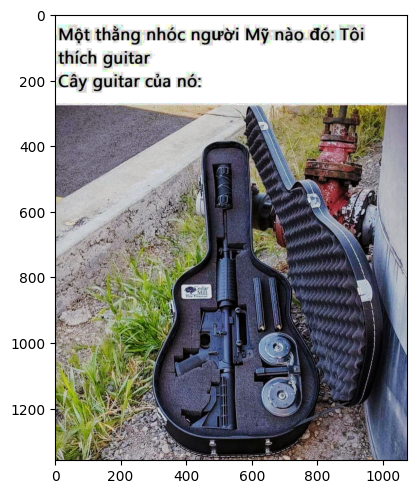

In [75]:
tensor_value_info(image)
aug_img = HistogramEqualization()(image)
tensor_value_info(aug_img)

visual_image([aug_img], [''])

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 130.515 >


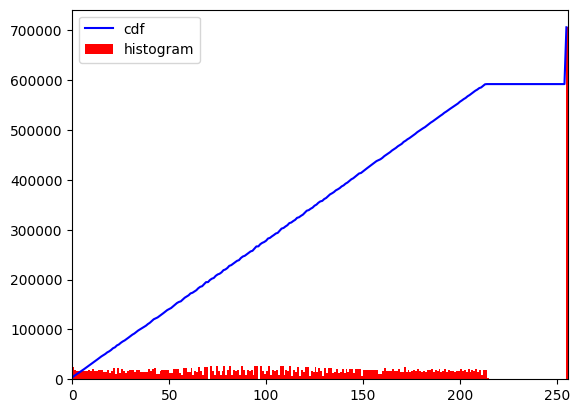

In [76]:
tensor_value_info(aug_img)

hist,bins = np.histogram(aug_img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(aug_img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [77]:
def solarize(image, threshold=128):
    img = image.copy()
    idx = img >= threshold
    img[idx] = 255 - image[idx]
    return img


class Solarize(BaseTransform):
    def __init__(self, threshold=128):
        self.threshold = threshold

    def image_transform(self, image):
        return solarize(image, self.threshold)


class RandomSolarize(BaseRandomTransform):
    def __init__(self, threshold=128, prob=0.5):
        self.threshold = threshold
        self.prob = prob

    def image_transform(self, image):
        return solarize(image, self.threshold)

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 127.000 mean: 66.249 >


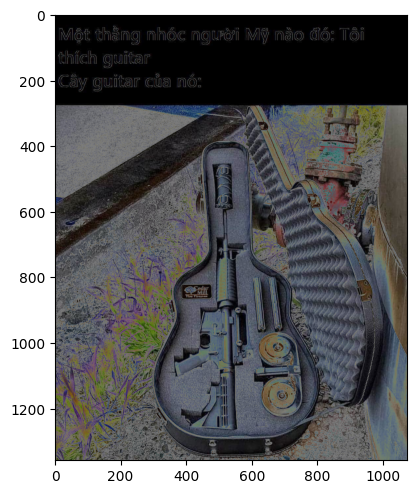

In [78]:
tensor_value_info(image)
aug_img = Solarize()(image)
tensor_value_info(aug_img)

visual_image([aug_img], [''])

In [89]:
def solarize_add(image, add_value, threshold=128):
    img = image.copy()
    idx = img < threshold
    img[idx] = np.minimum(image[idx] + add_value, 255)
    return img

class SolarizeAdd(BaseTransform):
    def __init__(self, add_value, threshold=128):
        self.add_value = add_value
        self.threshold = threshold

    def image_transform(self, image):
        return solarize_add(image, self.add_value, self.threshold)


class RandomSolarizeAdd(BaseRandomTransform):
    def __init__(self, add_value, threshold=128, prob=0.5):
        self.add_value = add_value
        self.threshold = threshold
        self.prob = prob

    def image_transform(self, image):
        return solarize_add(image, self.add_value, self.threshold)


< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 30.000 max: 255.000 mean: 156.015 >


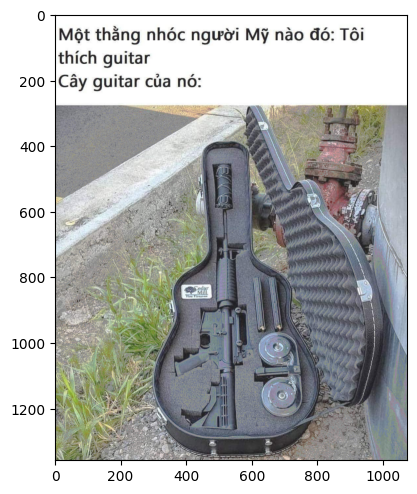

In [91]:
tensor_value_info(image)
aug_img = SolarizeAdd(30, 128)(image)
tensor_value_info(aug_img)

visual_image([aug_img], [''])

In [99]:
def posterize(image, bits):
    img = image.copy()

    if bits >= 8:
        return img

    mask = ~(2 ** (8 - bits) - 1)
    img = img & mask
    return img


class Posterize(BaseTransform):
    def __init__(self, bits):
        self.bits = bits

    def image_transform(self, image):
        return posterize(image, self.bits)


class RandomSolarizeAdd(BaseRandomTransform):
    def __init__(self, bits, prob=0.5):
        self.bits = bits
        self.prob = prob

    def image_transform(self, image):
        return posterize(image, self.bits)


< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: int16 min: 0.000 max: 240.000 mean: 132.528 >


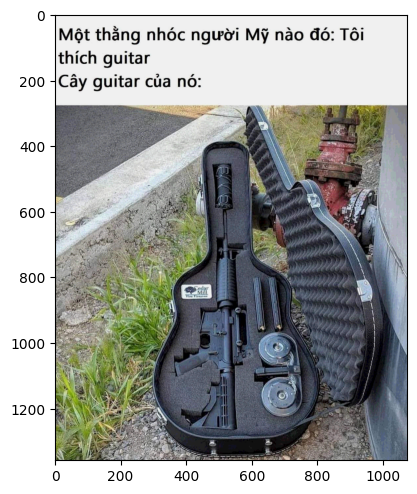

In [97]:
tensor_value_info(image)
aug_img = posterize(image, 4)
tensor_value_info(aug_img)

visual_image([aug_img], [''])

In [127]:
def desaturate(image, percent):
    img = image.copy()

    if percent == 0:
        return img

    # convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)

    # desaturate
    s_desat = cv2.multiply(s, 1 - percent).astype(np.uint8)
    hsv_new = cv2.merge([h,s_desat,v])
    bgr_desat = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2BGR)

    # create 1D LUT for green
    # (120 out of 360) = (60 out of 180)  +- 25
    lut = np.zeros((1,256), dtype=np.uint8)
    white = np.full((1,50), 255, dtype=np.uint8)
    lut[0:1, 35:85] = white

    # apply lut to hue channel as mask
    mask = cv2.LUT(h, lut)
    mask = mask.astype(np.float32) / 255
    mask = cv2.merge([mask,mask,mask])

    # mask bgr_desat and img
    img = mask * bgr_desat + (1 - mask) * img
    img = img.clip(0,255).astype(np.uint8)
    return img

< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 141.262 >
< shape: (1358, 1074, 3) dtype: uint8 min: 0.000 max: 255.000 mean: 139.087 >


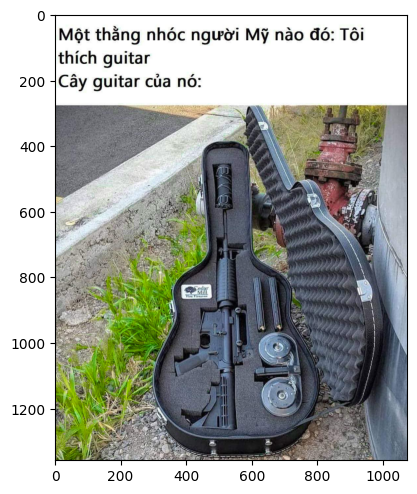

In [132]:
tensor_value_info(image)
aug_img = desaturate(image, -1.4)
tensor_value_info(aug_img)

visual_image([aug_img], [''])